# Frequentist Model Fitting

- *Jake VanderPlas*
- *ESAC statistics workshop, Oct 27-31 2014*
- *Source available on [github](http://github.com/jakevdp/ESAC-stats-2014)*
- *Youtube link* on [jakevdp](https://youtu.be/ljBhVbJ0QHU?si=Pma0x1KQB_INunFO)

## Preliminaries

These lectures will use Python tools, but won't go into too much depth on the Python side of things. That said, we'll always start with a block something like this, which sets up our notebook for inline plotting.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# from sklearn.datasets import make_blobs

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## Simple Model Fitting: Straight Line Fit

One of the most archetypical model fits you'll encounter is that of fitting a line to data.
We'll use the following randomly-generated dataset and discuss how we might fit this:

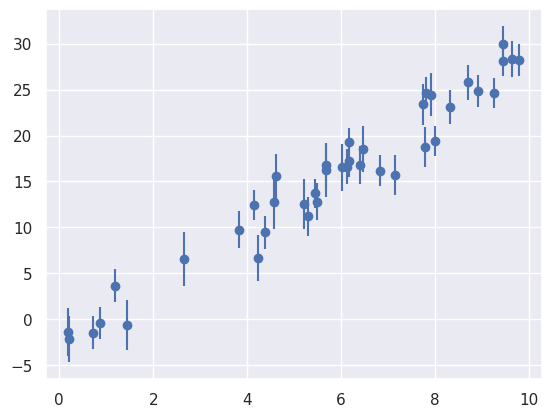

In [2]:
from fig_code import linear_data_sample
x, y, dy = linear_data_sample()
plt.errorbar(x, y, dy, fmt='o');

You can see these points have errors; for now let's ignore those errors and just look at the points themselves:

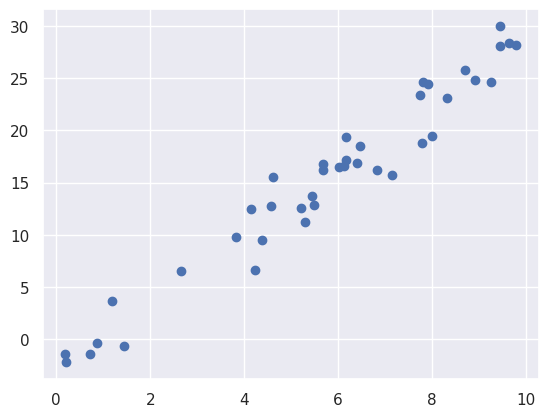

In [3]:
plt.plot(x, y, 'o');

Let's think about what it takes to fit a straight line to this data.

### Defining the Model

The first thing we must do is define our model. The *model* is usually some functional form which, as a function of various parameters, specifies what we **think** the data should look like.
In this case, we'll use a standard linear model defined by a slope *m* and an intercept *b*:

$$
M(x;m,b) = m x + b
$$

For clarity, we'll try to write our models in this way: to the left of the semicolon is our data, and to the right of the semicolon are our model parameters.

Now, examining our data above, we can quickly see that this model will **not** perfectly fit the data. So generally, what we're saying is that the data is distributed in some way around the model. For the most common assumption of normality, we're saying that

$$
y_i \sim \mathcal{N}[M(x;m,b), \sigma]
$$

but we'll get into this later.

### Defining a Cost Function

In order to fit a model to data, we need some way of *quantitatively* measuring how well a model with given parameters fits the data. That is, given a set of data $\{x_i, y_i\}$ and some parameters $\theta = \{m, b\}$, how well does the model fit? This is usually denoted via **Cost Function**, which tells us how far our model is from being ideal.

Specify the cost function & minimize it with respect to the model parameters, and you have your best fit! The cost function will look like this:

$$
C(\theta;\{x_i, y_i\}) = ??
$$

**Question: What are some cost functions we might use?**

Some ideas:

#### Least absolute deviation

$$
C_{LAD} = \sum_i \left|y_i - M(x_i;\theta)\right|
$$

#### Least Squares

$$
C_{LS} = \sum_i [y_i - M(x_i;\theta)]^2
$$

#### Least absolute N-th power?

$$
C_{LN} = \sum_i \left|y_i - M(x_i;\theta)\right|^N
$$

#### Least hyperbolic cosine?

$$
C_{LHC} = \sum_i \cosh[y_i - M(x_i;\theta)]
$$


We could literally use **any cost function we want**, though it's true that some have better properties than others, and are better motivated than others.
Probably the most commonly-used cost functions are the first two here: least absolute deviation and least squares.

### Trying it Out

Let's quickly code these up and see what happens:

In [4]:
def model(theta, x):
    b, m = theta
    return m * x + b

def least_abs_deviation(theta, x, y):
    return np.sum(abs(model(theta, x) - y))

def least_squares(theta, x, y):
    return np.sum((model(theta, x) - y) ** 2)

In [5]:
from scipy.optimize import fmin
theta_guess = [0, 1]

theta_LAD = fmin(least_abs_deviation, theta_guess, args=(x, y))
theta_LS = fmin(least_squares, theta_guess, args=(x, y))

Optimization terminated successfully.
         Current function value: 62.478260
         Iterations: 110
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 150.032670
         Iterations: 83
         Function evaluations: 156


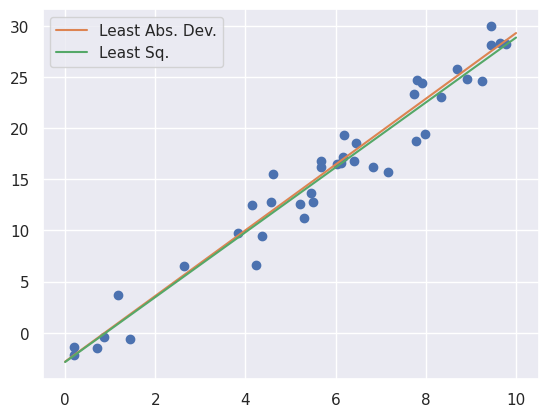

In [6]:
xfit = np.linspace(0, 10)

plt.plot(x, y, 'o')
plt.plot(xfit, model(theta_LAD, xfit), label='Least Abs. Dev.')
plt.plot(xfit, model(theta_LS, xfit), label='Least Sq.')
plt.legend(loc='best');

The results of both cost functions are similar! But this doesn't mean they're equal.
In particular, you may have noticed that **least squares** is used much more often than **least absolute deviation**. There are several reasons for this, but we'll see below that part of it is the equivalence with the likelihood.

## Motivating our Cost Function: the Likelihood

One way we can motivate the choice of cost function is to think of the problem probabilistically.

### Likelihood of a single point

Consider just a single point in our data, $(x, y)$. What are we **actually** trying to figure out?

Well, one way of looking at it is this: we know that for each $x$, there exists some "true" $y$ which we'll call $y_{true}$. But in our observing process, we have some probability distribution which describes how **likely** we are to observe a particular $y$ given the true $y$

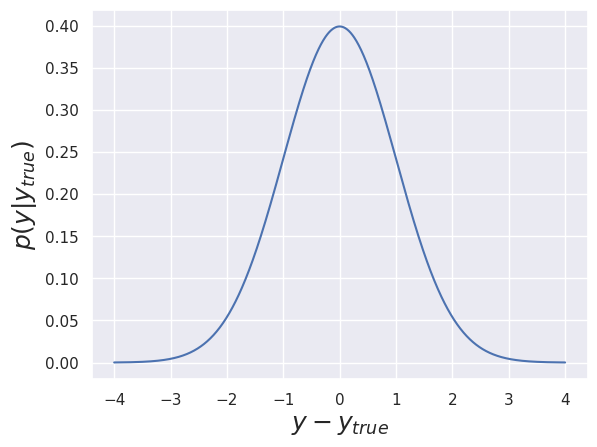

In [7]:
ydiff = np.linspace(-4, 4, 1000)
plt.plot(ydiff, stats.norm.pdf(ydiff, 0, 1))
plt.xlabel('$y - y_{true}$', size=18)
plt.ylabel('$p(y|y_{true})$', size=18);

Most commonly, we'll use a **normal (Gaussian) distribution** for this error.
This can be justified in a number of ways (Central limit theorem, maximum entropy, etc.). So in effect, what we're saying is that $y$ is a random variable, which is distributed like

$$
y \sim \mathcal{N}[y_{true}, \sigma^2]
$$

Given this (assumed) model for a single value of $y$, we can compute the probability of observing this point as follows:

$$
p(y|y_{true},\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[\frac{-(y - y_{true})^2}{2\sigma^2}\right]
$$

Here this should be read "the probability of $y$ given $y_{true}$ and $\sigma$ is..."

With this error distribution, we see that if our single observed point is far from the (unknown) true value, the probability is very low. If our single observed point is close to the true value, the probability is high.

### From Single Points to Two Points

Above we've computed the likelihood for a single point: this is just a probability that we'd see this point given an (unknown) true value. How do we then combine this likelihood for multiple points?

Essentially, we're asking **what is the joint probability of our points $y_1$ and $y_2$ given the true values $y_{1, true}$ and $y_{2, true}$?**
In symbols, we want:

$$
p(y_1, y_2~|~I)
$$

where $I$ is shorthand for the information we're using (here the true values & errors).
This is difficult to evaluate in general, but we can make one simplifying assumption that will change everything:

**Assumption: $y_1$ is *independent* of $y_2$.**

By the definition of independence, we can write

$$
p(y_1, y_2~|~I) = p(y_1~|~I) p(y_2~|~I)
$$

That is, independence lets us consider each measurement individually, and then multiply their probabilities together.

### From Two Points to $N$ Points

You might see where this is going: if every single draw from our model is *independent* (that is, the random error in one point does not affect the random error in any other point), then we can compute the likelihood of the entire dataset very easily!

$$
p(\{y_i\}~|~I) = \prod_{i=1}^N p(y_i~|~y_{i, true},\sigma)
$$

This product of probabilities is known as the **Likelihood**. If we take the logarithm of this expression, the product turns into a sum, and we have the **log-Likelihood**, which is often denoted as follows:

$$
\log L(\{y_i\}~|~I) = \sum_{i=1}^N \log p(y_i~|~y_{i, true},\sigma)
$$

### So What?

What we've created here is an expression, the **likelihood**, which depends on the data and our model for the true data.

Above we've been talking about the "true" $y$.
The problem is that we never actually know the true y! The true y (i.e. the best-fit model) is what we're trying to find.
Given this formalism, it can be motivated that **the model which maximizes this likelihood is the model which best fits the data**. What this is saying is, essentially, the model which gives our observed data the highest probability is the most likely model.

So: we need to maximize our likelihood (or equivalently, maximize our log-likelihood) by plugging-in the expression:

$$
y_{i, true} = m x_i + b
$$

### Maximizing our Likelihood

To do this, we'll start by plugging our Gaussian model into the log-likelihood. Doing this, we get the following:

$$
\log L(\{x_i, y_i\}~|~\theta, \sigma) = \frac{-N}{2}\log(2\pi\sigma^2) - \sum_{i=1}^N [(y_i - M(x_i;\theta))]^2
$$

OK... now we notice something. The second term here is **exactly** the least-squares cost function we proposed before!

$$
\log L(\{x_i, y_i\}~|~\theta, \sigma) = \frac{-N}{2}\log(2\pi\sigma^2) - C_{LS}(\{x_i, y_i\}~|~\theta)
$$

And notice something else: the first term is basically a constant, which means that *maximizing the likelihood is **identical** to minimizing the sum of squares!*

And this is one reason that least-squares fitting is so common: it follows from several assumptions:

1. The error distribution of the observed points is Gaussian.
2. The errors in observed points are independently drawn.
3. The model which is most likely to have led to our data is the optimal model.

**Question: what probability distribution for the data errors would lead to the least absolute deviation cost function?**

**Exercise: use the maximum likelihood to derive the expression for determining the mean of a set of data points**

## Closed-form Solution for Least Squares

Above we've been using an iterative solver for our least squares/maximum likelihood solution, but there is a better way! It turns out that using matrix methods, the least squares / Gaussian maximum likelihood problem can be solved in closed-form.

To do this, let's start by expressing our model as a matrix equation. We'll define the following two matrices:

$$
X = \left[
\begin{array}{ll}
  1 & x_1\\
  1 & x_2\\
  1 & x_3\\
  \vdots & \vdots\\
  1 & x_N
\end{array}
\right]~~~~
y = \left[
\begin{array}{l}
  y_1\\
  y_2\\
  y_3\\
  \vdots\\
  y_N
\end{array}
\right]
$$

The $X$ matrix here is sometimes known as the *design matrix*. This might look a bit strange, but if we now define the parameter vector $\theta = [b, m]$, we see that the model can simply be expressed as a simple matrix-vector product:

$$
y_{model} = X\theta
$$

we can write the likelihood as follows:

$$
L(x, y, dy~|~\theta) = (2\pi\sigma^2)^{-1/2}\exp\left(-\frac{1}{2\sigma^2}\|y - X\theta\|^2\right)
$$

minimizing this with respect to $\theta$ (by setting the derivative with respect to $\theta$ to zero) gives:

$$
X^T(y - X\hat{\theta}) = 0
$$

which yields the maximum likelihood solution:

$$
\hat{\theta} = [X^TX]^{-1}X^Ty
$$

Let's give this a try:

In [8]:
X = np.vstack([np.ones_like(x), x]).T

theta_hat = np.linalg.solve(np.dot(X.T, X),
                            np.dot(X.T, y))
print(theta_hat)
print(theta_LS)

[-2.85195862  3.16960077]
[-2.8519853   3.16960679]


We see that the result is the same as our previous least squares solution... it's just **much** faster to compute!
For good measure, let's again visualize this fit:

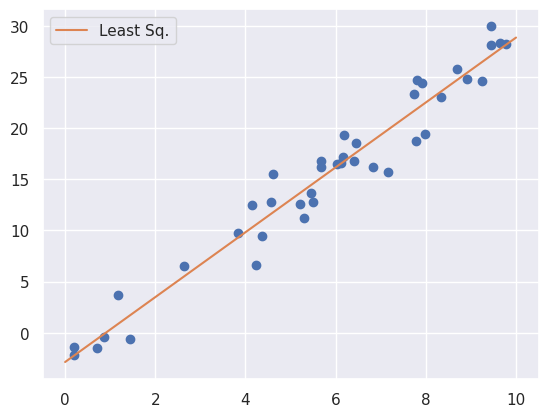

In [9]:
xfit = np.linspace(0, 10)

plt.plot(x, y, 'o')
plt.plot(xfit, model(theta_hat, xfit), label='Least Sq.')
plt.legend(loc='best');

## Model Fitting with Errors

The maximum likelihood formalism above gives us a natural means of including measurement errors in the dependent variables (i.e. $y$). We simply change the width of each individual Gaussian to reflect the (known) error in our data points!

That is, we use

$$
\log L(\{y_i\}~|~I) = \sum_{i=1}^N \log p(y_i~|~y_{i, true},\sigma_i)
$$

note the $\sigma_i$ at the end of the expression. From this, we can derive the weighted least-squares cost function:

$$
C_{LS}(\{x_i, y_i, \sigma_i\}~|~\theta) = \sum_i \frac{[y_i - M(x_i;\theta)]^2}{2\sigma_i^2}
$$

So already we've gained some insight about how to extend least-squares recipe into another regime!

But let's skip straight toward the closed form here. Based on some arguments we won't cover here, we'll start by defining an **error covariance matrix**:

$$
\Sigma = \left[
\begin{array}{lllll}
\sigma_1^2 & 0 & 0 & \cdots & 0\\
0 & \sigma_2^2 & 0 & \cdots & 0\\
0 & 0 & \sigma_3^2 & \cdots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & \cdots & \sigma_N^2
\end{array}
\right]
$$

we can write the likelihood as follows:

$$
L(x, y, dy~|~\theta) = (2\pi|\Sigma|)^{-1/2}\exp\left[-\frac{1}{2}(y - X\theta)^T\Sigma^{-1}(y - X\theta)\right]
$$

again minimizing this with respect to $\theta$ gives:

$$
X^T\Sigma^{-1}(y - X\hat{\theta}) = 0
$$

which yields the maximum likelihood solution:

$$
\hat{\theta} = [X^T\Sigma^{-1}X]^{-1}X^T\Sigma^{-1}y
$$

So this is very similar to our previous closed-form solution, except with some diagonal error matrices thrown in. Let's compute this:

In [10]:
XT_Sigma_X = np.dot(X.T / dy ** 2, X)
XT_Sigma_y = np.dot(X.T / dy ** 2, y)
theta_LS_err = np.linalg.solve(XT_Sigma_X, XT_Sigma_y)

Let's use this with our full data + errors to find a fit to the data:

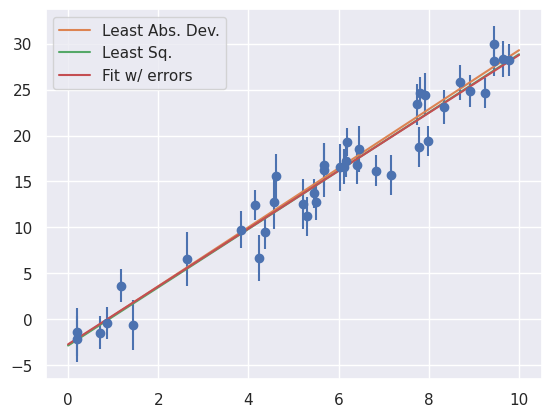

In [11]:
plt.errorbar(x, y, dy, fmt='o')
plt.plot(xfit, model(theta_LAD, xfit), label='Least Abs. Dev.')
plt.plot(xfit, model(theta_LS, xfit), label='Least Sq.')
plt.plot(xfit, model(theta_LS_err, xfit), label='Fit w/ errors')
plt.legend(loc='best');

All three results are very similar.

But what if some of our data points have very large errors?

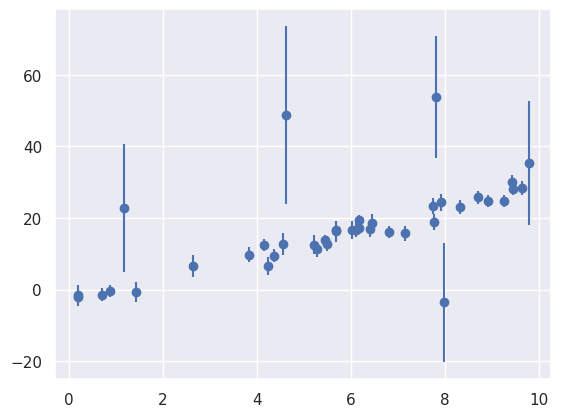

In [12]:
from fig_code import linear_data_sample_big_errs
x, y, dy = linear_data_sample_big_errs()
plt.errorbar(x, y, dy, fmt='o');

Let's redo the fit now with and without the errorbars:

In [13]:
theta_LAD = fmin(least_abs_deviation, theta_guess, args=(x, y))

X = np.vstack([np.ones_like(x), x]).T

theta_LS = np.linalg.solve(np.dot(X.T, X),
                           np.dot(X.T, y))

theta_LS_err = np.linalg.solve(np.dot(X.T / dy ** 2, X),
                               np.dot(X.T / dy ** 2, y))

Optimization terminated successfully.
         Current function value: 173.046330
         Iterations: 120
         Function evaluations: 220


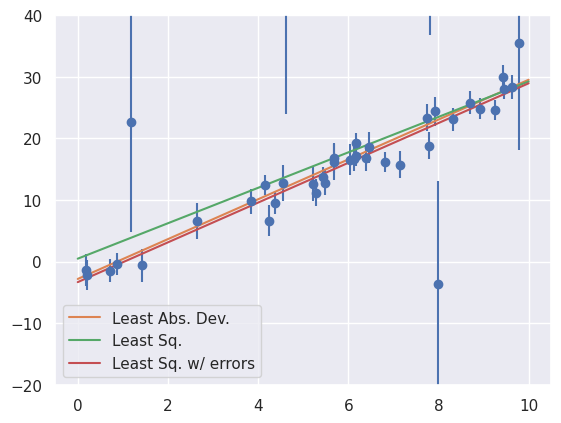

In [14]:
plt.errorbar(x, y, dy, fmt='o')
plt.ylim(-20, 40)
plt.plot(xfit, model(theta_LAD, xfit), label='Least Abs. Dev.')
plt.plot(xfit, model(theta_LS, xfit), label='Least Sq.')
plt.plot(xfit, model(theta_LS_err, xfit), label='Least Sq. w/ errors')
plt.legend(loc='best');

Notice something interesting: the errors have a much larger effect on the least squares solution than on the Least Absolute Deviation solution! This is reflective of the well-known fact that the LAD solution is more robust to outliers than is the least squares solution.

## Generalized Linear Models

One of the powerful applications of the above formalism is its use in **generalized linear models**. Essentially, we can modify the $X$ matrix at will to quickly find closed-form solutions to a large number of problems.  For example, we could fit a third-order polynomial model such as the following:

$$
y_{model} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^2
$$

All that takes is to compute the above solution, but use the following $X$ matrix:

$$
X = \left[
\begin{array}{llll}
  1 & x_1 & x_1^2 & x_1^3\\
  1 & x_2 & x_2^2 & x_2^3\\
  1 & x_3 & x_3^2 & x_3^3\\
  \vdots & \vdots & \vdots & \vdots\\
  1 & x_N & x_N^2 & x_N^3
\end{array}
\right]
$$

We could, of course, add any number of columns to make the polynomial as high as we'd like.

Similarly, we could fit a periodic model to data such as this one:

$$
y_{model} = \theta_0 + \theta_1\sin(\omega x) + \theta_2\cos(\omega x)
$$

For this, we use the following $X$ matrix:

$$
X = \left[
\begin{array}{lll}
  1 & \sin(\omega x_1) & \cos(\omega x_1)\\
  1 & \sin(\omega x_2) & \cos(\omega x_2)\\
  1 & \sin(\omega x_3) & \cos(\omega x_3)\\
  \vdots & \vdots & \vdots \\
  1 & \sin(\omega x_N) & \cos(\omega x_N)\\
\end{array}
\right]
$$

Note that for the model to be linear, we must **specify** $\omega$. We could use the maximum likelihood approach to fit for $\omega$ itself, but it will no longer be a linear model.

In the morning breakout session, we'll explore the construction of some of these generalized linear models.